In [11]:
import sys
sys.path.append('../')

In [13]:
from simulation_functions import index, simulation_, plot
from interpolation_functions import T_K
import numpy as np
import matplotlib.pyplot as plt


In [21]:
t_drive_new = np.loadtxt('../t_drive_new.txt') # true time sample. 
ind = index(15,t_drive_new) # 15 means that the time delay is chosen randomly between 0 and 15 days

In [27]:
# getting the indices of each time shifter curve 
index0 = ind[0]
index1 = ind[1]
index2 = ind[2]
index3 = ind[3]
sample = np.sort(ind[5])

#getting the time sample of each curve
ts_0 = sample[index0]
ts_1 = sample[index1]
ts_2 = sample[index2]
ts_3 = sample[index3]
ts = np.array([ts_0,ts_1,ts_2,ts_3])

# finding the magnitudes corresponding to each time shifted sample
f = simulation_(sample) #running simulation
fs_0 = f[index0]
fs_1 = f[index1]
fs_2 = f[index2]
fs_3 = f[index3]

# desired sampling for each curve
h=3
tk_0 = T_K(h,ts_0)[0]
tk_1 = T_K(h,ts_1)[0]
tk_2 = T_K(h,ts_2)[0]
tk_3 = T_K(h,ts_3)[0]
tk = np.array([tk_0,tk_1,tk_2,tk_3])

time_delays = ind[6] 


In [28]:
# sinc matrix
a = np.array([(ts_0[:,np.newaxis]+time_delays[0])-tk_0[np.newaxis,:]])
b = np.array([(ts_1[:,np.newaxis]+time_delays[1])-tk_1[np.newaxis,:]])
c = np.array([(ts_2[:,np.newaxis]+time_delays[2])-tk_2[np.newaxis,:]])
d = np.array([(ts_3[:,np.newaxis]+time_delays[3])-tk_3[np.newaxis,:]])
sinc_matrix = np.sinc(np.concatenate([a,b,c,d],axis =0)/h)
#sinc_matrix.shape # 4 x s x k

In [29]:
B= np.concatenate([fs_0[np.newaxis,:],fs_1[np.newaxis,:],fs_2[np.newaxis,:],fs_3[np.newaxis,:]])
# B.shape # 4 x s

In [33]:
def solution_gd(i): 
    '''
    Solution of matrix equation using gradient descent
    input:
    i : the number of shifted curve desired to solve for, options are 0,1,2,3
    output: 
    plots of the solution
    '''
    A = sinc_matrix[i]
    Y = B[i]
    def linorm(S, nit):
        n1, n2 = np.shape(S)
        x0 = np.random.rand(1, n1)
        x0 = x0 / np.sqrt(np.sum(x0 ** 2))    
        for i in range(nit):
            x = np.dot(x0, S)
            xn = np.sqrt(np.sum(x ** 2))
            xp = x / xn
            y = np.dot(xp, S.T)
            yn = np.sqrt(np.sum(y ** 2))       
            if yn < np.dot(y, x0.T):
                break
            x0 = y / yn
        return 1./xn

    mu = linorm(A, 20)/100.

    X = np.zeros(len(tk[i]))

    count = 0
    R = [np.sum(Y**2)]
    epsilon = 0.3

    while (R[-1] > epsilon) and (count < 100000): # calculated this norm^2 for the least squares sol it gave 0.5 so I chose 0.5>0.3
        X_new = X + mu*((A.T)@(Y-A@X))
        X = X_new.copy()
        R.append(np.sum((Y-A@X)**2.))
        count+=1
        
    plt.title('Convergence')
    plt.plot(np.array(R[1:]))
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.show()
    
    cut = np.logical_and(X < np.max(Y), X > np.min(Y))
    plt.plot(ts[i],Y,'o',label = 'original')
    plt.plot(tk[i][cut],X[cut],'o',label='interpolated', color = 'orange')
    plt.xlabel('time[days]')
    plt.ylabel('magnitude')
    plt.title('sinc interpolated values')
    plt.legend()
    plt.show()

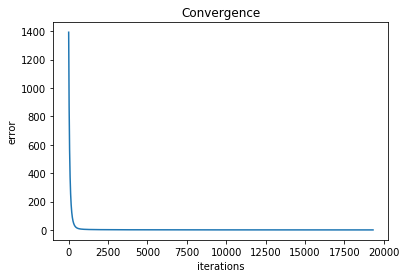

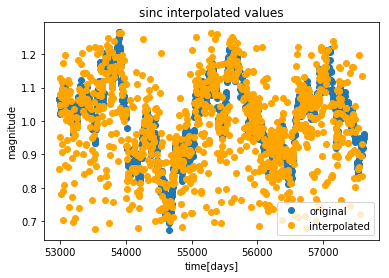

In [34]:
solution_gd(0) # replace 3 with 0,1,2 for other curves